In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import h5py

## Task 1: CNNs for Galaxy Classification

In [2]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "data/Galaxy10.h5"
)

In [ ]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])


### (a)

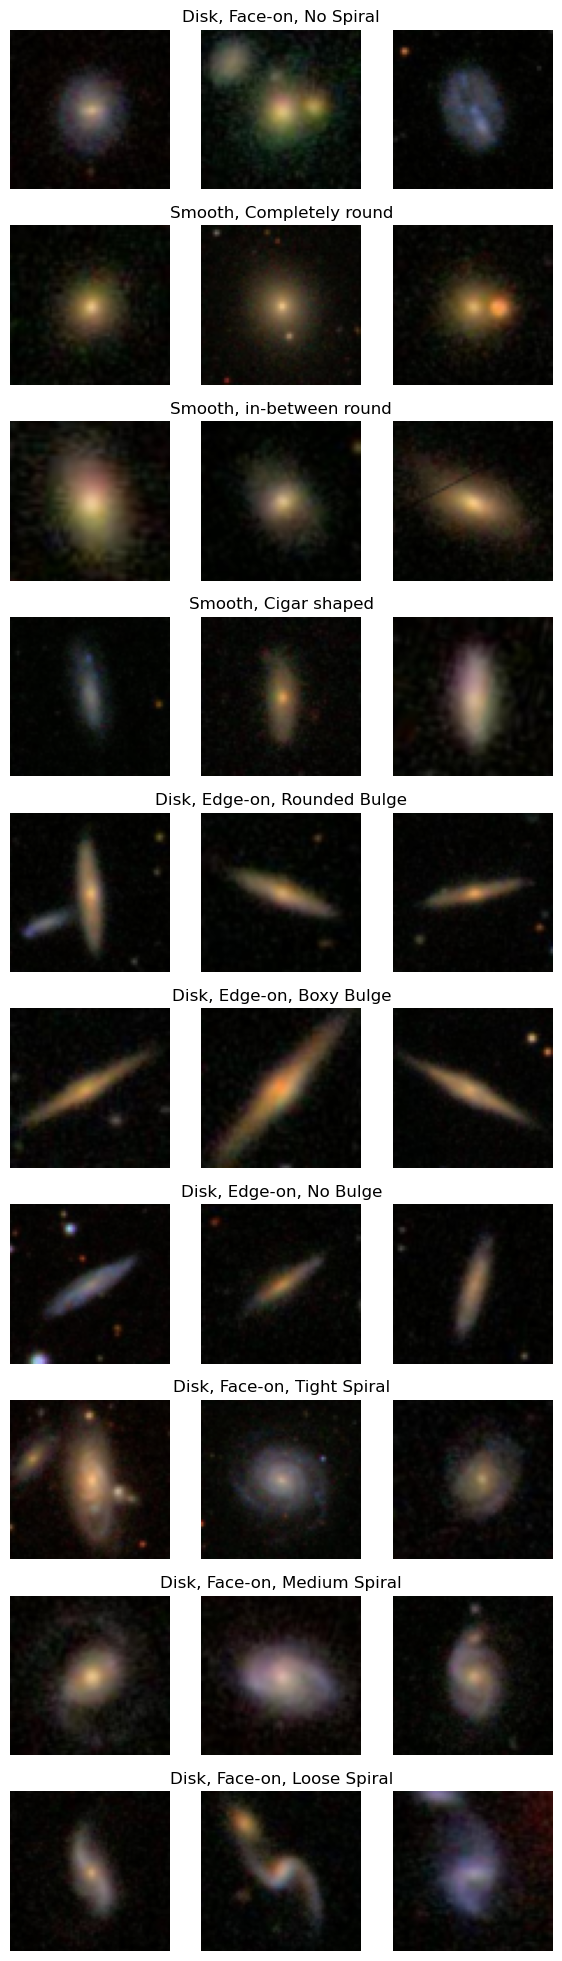

In [ ]:
# plot three samples of each class
class2samples = {i: [] for i in range(n_classes)}
for i, label in enumerate(labels.numpy()):
    class2samples[label].append(i)

fig, ax = plt.subplots(n_classes, 3)

for i in range(n_classes):
    for j in range(3):
        ax[i, j].imshow(torch.permute(images[class2samples[i][j], :, :, :], (1, 2, 0)).numpy().astype(np.uint8))
        ax[i, j].axis('off') 
    ax[i, 1].set_title(label_names[i])

fig.set_figwidth(7)
fig.set_figheight(25)
plt.show()


In [ ]:
from torchvision.transforms import Normalize
from sklearn.model_selection import train_test_split

#Split the data and normalize the images:
print("To normalize images we need to compute mean and standard deviation for each channel.\n")
images_normalized = []
for img in images:
    means = []
    stds = []
    for i in range(3):
        means.append(torch.mean(img[i, :, :]))
        stds.append(torch.std(img[i, :, :]))
    
    norm_transform = Normalize(means, stds)
    images_normalized.append(norm_transform(img))

images_train, images_test_and_valid, labels_train, labels_test_and_valid = train_test_split(images, labels, test_size=0.2)
images_test, images_valid, labels_test, labels_valid = train_test_split(images_test_and_valid, labels_test_and_valid, test_size=0.5)

print(f'{images_train.shape=}, {labels_train.shape=}')
print(f'{images_test.shape=}, {labels_test.shape=}')
print(f'{images_valid.shape=}, {labels_valid.shape=}')


#Create tensordatasets and data loaders:
dataset_train = TensorDataset(images_train, labels_train)
dataset_test = TensorDataset(images_test, labels_test)
dataset_valid = TensorDataset(images_valid, labels_valid)

data_loader_train = DataLoader(dataset_train, batch_size=8, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, drop_last=True)
data_loader_valid = DataLoader(dataset_valid, batch_size=8, shuffle=True, drop_last=True)

To normalize images we need to compute mean and standard deviation for each channel.

images_train.shape=torch.Size([17428, 3, 69, 69]), labels_train.shape=torch.Size([17428])
images_test.shape=torch.Size([2178, 3, 69, 69]), labels_test.shape=torch.Size([2178])
images_valid.shape=torch.Size([2179, 3, 69, 69]), labels_valid.shape=torch.Size([2179])


### (b)

In [2]:
#TODO: implement a small CNN as specified on the sheet
from torch import nn
import torch.nn.functional as F

class GalaxyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 5)
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(14 * 14 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 

### (c) + (d) + (e)

In [ ]:
import torch.optim as optim

# Instantiate the model, optimizer and criterion
model = GalaxyCNN()

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("For classification the most popular loss is the cross-entropy loss,\nso we will use it.\n")

train_losses = []
train_accs = []
val_losses = []
val_accs = []

def get_predictions(outputs):
    return torch.argmax(F.softmax(outputs, dim=1), dim=1)

def calculate_accuracy(outputs, labels):
    predictions = get_predictions(outputs)
    return (predictions == labels).float().sum() / len(outputs)


def validate(model, dataset=data_loader_valid):
    losses = []
    correct = []

    #The validation loop
    for i, data in enumerate(dataset, 0):
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        losses.append(loss.item())
        correct.append(calculate_accuracy(outputs, labels))

    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy


print("Initial validation metrics")
val_loss, val_acc = validate(model)
val_losses.append(val_loss)
val_accs.append(val_acc)

best_val_loss = val_loss
best_val_epoch = 0

print("Initial training metrics")
train_loss, train_acc = validate(model, dataset=data_loader_train)
train_losses.append(train_loss)
train_accs.append(train_acc)

print("Training....")
print("Validation metrics:")
for epoch in range(30):
    train_losses_epoch = []
    train_accs_epoch = []
    for i, data in enumerate(data_loader_train, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses_epoch.append(loss.item())
        train_accs_epoch.append(calculate_accuracy(outputs, labels))

    avg_train_loss_epoch = np.mean(np.array(train_losses_epoch))
    avg_train_acc_epoch = np.mean(np.array(train_accs_epoch))
    train_losses.append(avg_train_loss_epoch)
    train_accs.append(avg_train_acc_epoch)

    curr_loss, curr_acc = validate(model)
    val_losses.append(curr_loss)
    val_accs.append(curr_acc)

    if(curr_loss < best_val_loss):
        print("Best model so far!")
        best_val_loss = curr_loss
        best_val_epoch = epoch
        torch.save(model.state_dict(), 'best_model_weights.pth')

For classification the most popular loss is the cross-entropy loss,
so we will use it.

Initial validation metrics
accuracy=0.29, avg_loss=2.08e+00
Initial training metrics
accuracy=0.28, avg_loss=2.08e+00
Training....
Validation metrics:
accuracy=0.57, avg_loss=1.06e+00
Best model so far!
accuracy=0.68, avg_loss=8.40e-01
Best model so far!
accuracy=0.68, avg_loss=8.74e-01
accuracy=0.69, avg_loss=8.34e-01
Best model so far!
accuracy=0.73, avg_loss=8.32e-01
Best model so far!
accuracy=0.72, avg_loss=8.74e-01
accuracy=0.72, avg_loss=8.32e-01
accuracy=0.73, avg_loss=9.51e-01
accuracy=0.72, avg_loss=9.00e-01
accuracy=0.72, avg_loss=9.62e-01
accuracy=0.72, avg_loss=1.00e+00
accuracy=0.70, avg_loss=1.25e+00
accuracy=0.71, avg_loss=1.20e+00
accuracy=0.71, avg_loss=1.19e+00
accuracy=0.70, avg_loss=1.36e+00
accuracy=0.72, avg_loss=1.43e+00
accuracy=0.71, avg_loss=1.60e+00
accuracy=0.70, avg_loss=1.76e+00
accuracy=0.68, avg_loss=1.84e+00
accuracy=0.67, avg_loss=1.82e+00
accuracy=0.69, avg_loss=1

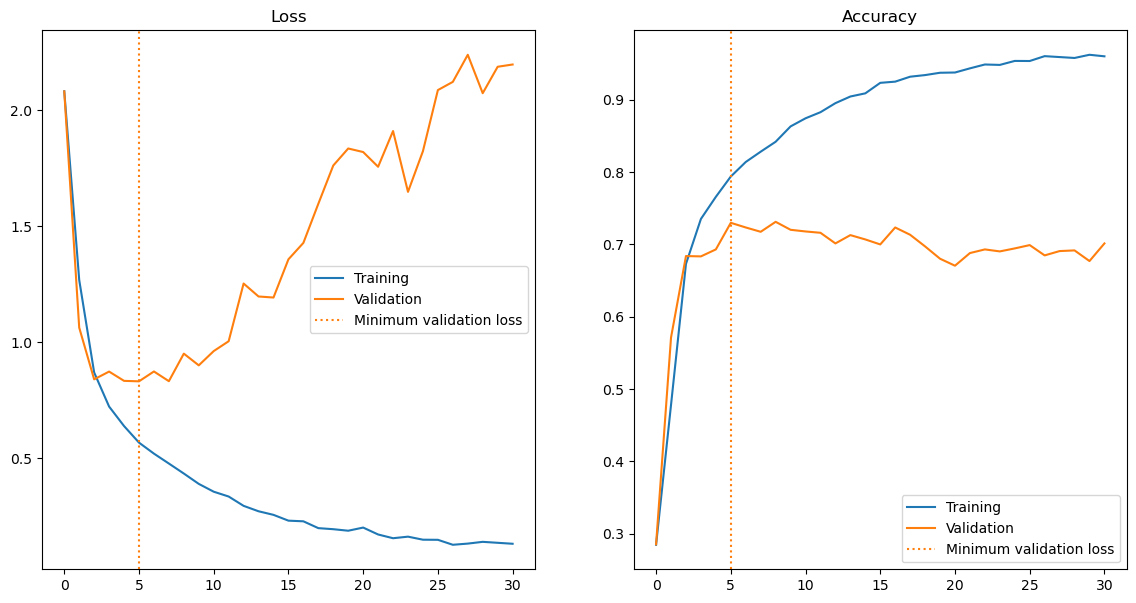

In [88]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_losses, color='C0', label="Training")
ax[0].plot(val_losses, color='C1', label="Validation")
ax[0].axvline(best_val_epoch + 1, color='C1', ls=':', label="Minimum validation loss")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(train_accs, color='C0', label="Training")
ax[1].plot(val_accs, color='C1', label="Validation")
ax[1].axvline(best_val_epoch + 1, color='C1', ls=':', label="Minimum validation loss")
ax[1].set_title("Accuracy")
ax[1].legend()


fig.set_figwidth(14)
fig.set_figheight(7)
plt.show()


We see a classic plot of training vs validation. For several epochs both the training and the validation losses become smaller (and the accuracy becomes larger). But after the 5th epoch the loss on the validation dataset starts to become larger and the accuracy grows smaller, meaning that our model starts to overfit.

### (e) continued

Test metrics:
accuracy=0.74, avg_loss=7.97e-01


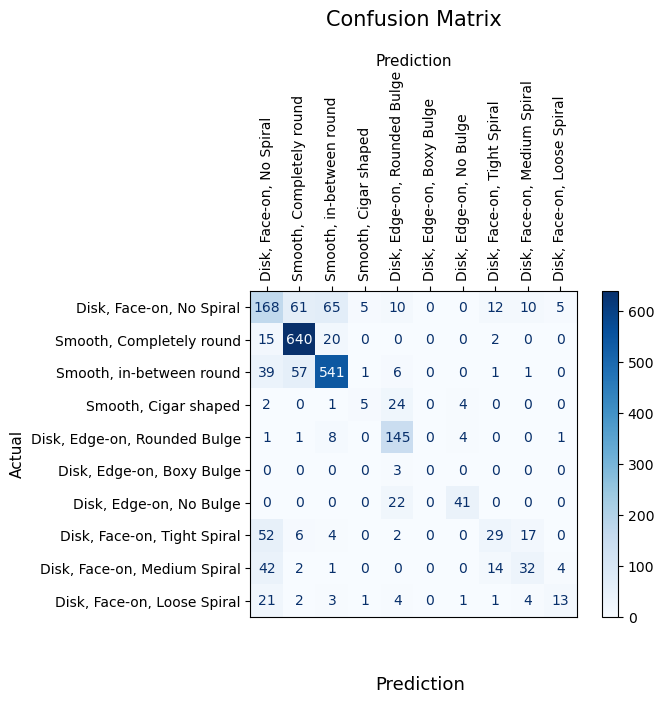

In [118]:
# TODO: Evaluate the best validation model on the test set and create a confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = GalaxyCNN()
best_model.load_state_dict(torch.load('best_model_weights.pth', weights_only=True))
best_model.eval()

print("Test metrics:")
test_loss, test_acc = validate(best_model, data_loader_test)

y_pred_idx = []
y_true_idx = []
for i, data in enumerate(data_loader_test, 0):
    inputs, labels = data
    outputs = best_model(inputs)

    y_true_idx += labels
    y_pred_idx += get_predictions(outputs)

y_true = [label_names[i] for i in y_true_idx]
y_pred = [label_names[i] for i in y_pred_idx]

cm = confusion_matrix(y_true, y_pred, labels=label_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.xticks(rotation='vertical')
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()


On this plot we can see, where the model has trouble predicting a class: for instance it is difficult for the model to differentiate between different "Disk, Face-on" galaxies. There is also too much data for the "Smooth, Completely round" and "Smooth, in-between round" classes compared to the other classes, which could skew the model's predictions. Although the classification is not perfect, still the model is able for the most part to distinguish between main classes:  "Disk" and "Smooth".
